In [1]:
import cv2
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from photon_canon.contrib.bio import wl, eps
from photon_canon.contrib.bio import hemoglobin_mus
from photon_canon.lut import LUT

from hsdfmpm.hsdfm.utils import find_cycles, gabor_filter_bank, naive_leastsq_reflectance
from hsdfmpm.utils import apply_kernel_bank, truncate_colormap, colorize
from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from hsdfmpm.mpm import OpticalRedoxRatio, LifetimeImage

plt.set_cmap('gray')
plt.close('all')

In [2]:
std_paths = find_cycles(r'D:\Jesse\hsdfmpm_poc\Standards')
bg_paths = find_cycles(r'D:\Jesse\hsdfmpm_poc\Background')
hs_path = r'D:\Jesse\Animal POC\06072025\1782NT\100\fov3\cycle1'
flim_path = r'D:\Jesse\Animal POC\06072025\1782NT\100\fov3_flim_755-092'
ex755_path = r'D:\Jesse\Animal POC\06072025\1782NT\100\fov3_redox_755-091'
ex855_path = r'D:\Jesse\Animal POC\06072025\1782NT\100\fov3_redox_855-090'
lsr_pwr_path = r'D:\Jesse\Animal POC\Laser Power'

In [3]:
smoothing_fn = partial(cv2.GaussianBlur, ksize=(3, 3), sigmaX=2)
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=110, smoothing_fn=smoothing_fn)
X, Y, Z = lut.surface()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='3d'))
ax.plot_wireframe(Y, X / 10, smoothing_fn(Z))
ax.set(xlabel=r"$\mu_a\, \mathrm{ (cm^{-1})}$", ylabel=r"$\mu_s'\, \mathrm{ (cm^{-1})}$", zlabel=r"$R_m \mathrm{ (a.u)}$", title=r"Monte Carlo Lookup Table")
plt.tight_layout()
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_333280\2707364902.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set(xlabel="$\mu_a\, \mathrm{ (cm^{-1})}$", ylabel="$\mu_s'\, \mathrm{ (cm^{-1})}$", zlabel="$R_m \mathrm{ (a.u)}$", title="Monte Carlo Lookup Table")
C:\Users\jdivers\AppData\Local\Temp\ipykernel_333280\2707364902.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set(xlabel="$\mu_a\, \mathrm{ (cm^{-1})}$", ylabel="$\mu_s'\, \mathrm{ (cm^{-1})}$", zlabel="$R_m \mathrm{ (a.u)}$", title="Monte Carlo Lookup Table")
C:\Users\jdivers\AppData\Local\Temp\ipykernel_333280\2707364902.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set(xlabel="$\mu_a\, \mathrm{ (cm^{-1})}$

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [4]:
# Find raw data
wavelengths = np.arange(500, 730, 10)

# Load normalization data
standard = MergedHyperspectralImage(image_paths=std_paths, scalar=0.80, wavelengths=wavelengths)
standard.normalize_integration_time()
background = MergedHyperspectralImage(image_paths=bg_paths, wavelengths=wavelengths)
background.normalize_integration_time()

[None, None, None]

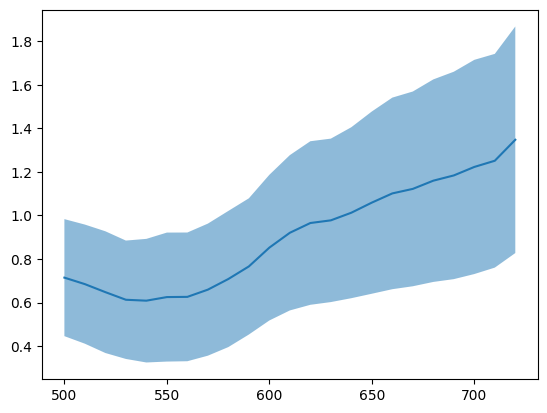

In [5]:
# Load data and normalize
hs = HyperspectralImage(image_path=hs_path, standard=standard, background=background, wavelengths=wavelengths)
hs.normalize()
means = np.nanmean(hs, axis=(1, 2))
wls = hs.metadata['Wavelength']
plt.plot(wls, means)

stdevs = np.nanstd(hs, axis=(1, 2))
plt.fill_between(wls, means - stdevs, means + stdevs, alpha=0.5)
plt.show()
hs.resize_to(256)

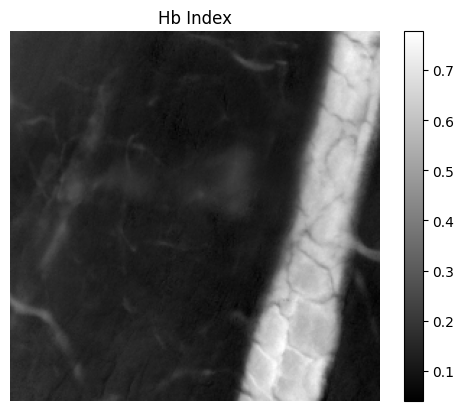

In [6]:
# Get variables for naive fit
absorption_dominated_wavelengths = np.arange(500, 610, 10)
selected = np.isin(wl, absorption_dominated_wavelengths)
e = eps[:, selected]

# Fit the image with naive lsq and apply gabor bank
hs.subset_by_metadata('Wavelength', absorption_dominated_wavelengths)
naive_fit = naive_leastsq_reflectance(hs.image, e)
hb_index = naive_fit[0] + naive_fit[1]
plt.imshow(hb_index)
plt.title('Hb Index')
plt.axis('off')
plt.colorbar()
plt.show()

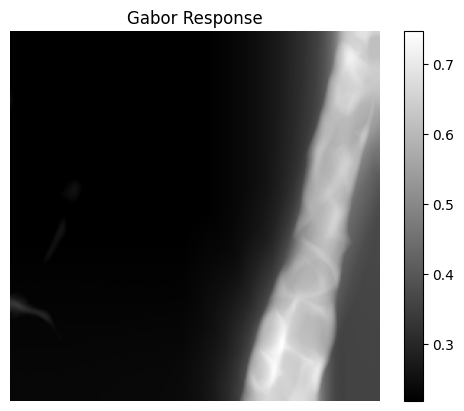

In [7]:
# Apply chosen Gabor design
f = np.geomspace(0.01, 1, 16)
gabor_response = apply_kernel_bank(hb_index, gabor_filter_bank(frequency=f, sigma_x=4/f, sigma_y=1/f))
plt.imshow(gabor_response)
plt.title('Gabor Response')
plt.axis('off')
plt.colorbar()
plt.show()

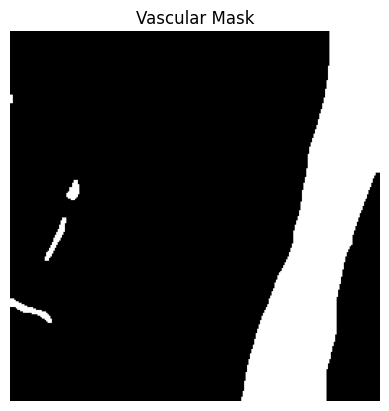

In [8]:
blurred_gabor_response_map = cv2.GaussianBlur(gabor_response, (3, 3), 0.5)
uint8_resp = (255 * (blurred_gabor_response_map / blurred_gabor_response_map.max())).astype(np.uint8)
threshold = (blurred_gabor_response_map.max() / 255) * cv2.threshold(uint8_resp, 0, 255, cv2.THRESH_OTSU)[0]
otsu_mask = blurred_gabor_response_map > threshold
opened_adaptive_mask = cv2.morphologyEx(
    cv2.adaptiveThreshold(uint8_resp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0),
    cv2.MORPH_OPEN,
    np.ones((3, 3))
).astype(bool)
mask = np.logical_or(otsu_mask, opened_adaptive_mask)
fig, ax = plt.subplots(1, 1)
ax.imshow(mask)
ax.axis('off')
ax.set_title('Vascular Mask')
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\3138267241.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(absorption_dominated_wavelengths, in_means - in_stdevs, in_means + in_stdevs, alpha=0.5, label="$\pm \sigma$")
C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\3138267241.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(scatter_dominated_wavelengths, out_means - out_stdevs, out_means + out_stdevs, alpha=0.5, label="$\pm \sigma$")


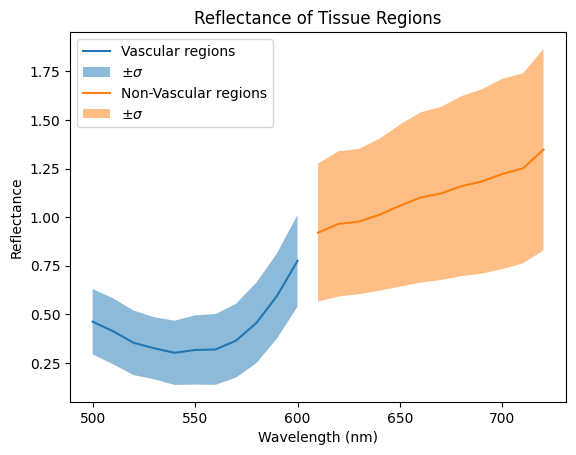

In [9]:
hs.superset()

abs_idx = np.array([wl in absorption_dominated_wavelengths for wl in hs.metadata['Wavelength']])

scatter_dominated_wavelengths = np.arange(610, 730, 10)
sca_idx = np.array([wl in scatter_dominated_wavelengths for wl in hs.metadata['Wavelength']])

hs.superset()
total_image = hs.image.copy()
in_data = total_image[abs_idx] * mask[np.newaxis, ...]
in_data[:, ~mask] = np.nan
out_data = total_image[sca_idx]
in_means = np.nanmean(in_data, axis=(1, 2))
out_means = np.nanmean(out_data, axis=(1, 2))

in_stdevs = np.nanstd(in_data, axis=(1, 2))
out_stdevs = np.nanstd(out_data, axis=(1, 2))

plt.plot(absorption_dominated_wavelengths, in_means, label="Vascular regions")
plt.fill_between(absorption_dominated_wavelengths, in_means - in_stdevs, in_means + in_stdevs, alpha=0.5, label="$\pm \sigma$")
plt.plot(scatter_dominated_wavelengths, out_means, label="Non-Vascular regions")
plt.fill_between(scatter_dominated_wavelengths, out_means - out_stdevs, out_means + out_stdevs, alpha=0.5, label="$\pm \sigma$")

plt.title('Reflectance of Tissue Regions')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')

plt.legend()
plt.show()

In [11]:
from tqdm.contrib.itertools import product
from hsdfmpm.hsdfm.fit import fit_voxel
g = 0.9

mu_s, mu_a, _ = hemoglobin_mus(10, 1, 0, 0, scatter_dominated_wavelengths, force_feasible=False)
mu_s /= (1 - g)
r = lut(mu_s, mu_a)
def baseline_offest(C):
    return r + C

rng = np.random.default_rng(42)
param_image = np.zeros_like(hs.image[0])
chi_sq = np.zeros_like(hs.image[0])
scatter_image = total_image[sca_idx]
for i, j in product(range(0, 256), range(0, 256)):
    if np.all(np.isnan(scatter_image[:, i, j])):
        pi, cs = np.nan, np.nan
    else:
        pi, cs = fit_voxel(
            out_data[:, i, j],
            model=baseline_offest,
            x0=[0],
            max_nfev=5000
        )
    param_image[i, j] = pi
    chi_sq[i, j] = cs

  0%|          | 0/65536 [00:00<?, ?it/s]

C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\1708935943.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_image[i, j] = pi


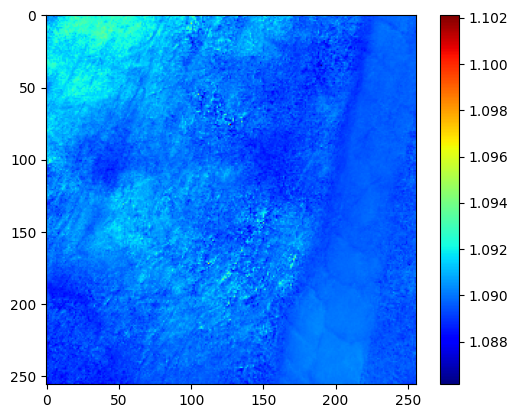

In [12]:
plt.imshow(chi_sq, cmap='jet')
plt.colorbar()

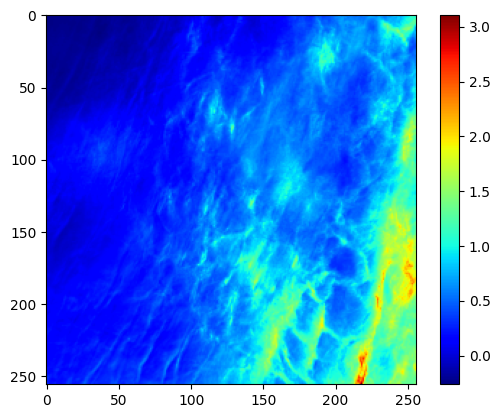

In [13]:
C = param_image
plt.imshow(C, cmap='jet')
plt.colorbar()

In [14]:
from tqdm.contrib.itertools import product
from hsdfmpm.hsdfm.fit import fit_voxel
g = 0.9

def model(t, s, c):
    mu_s, mu_a, _ = hemoglobin_mus(10, 1, t, s, absorption_dominated_wavelengths, force_feasible=False)
    mu_s /= (1 - g)
    r = lut(mu_s, mu_a, extrapolate=True) + c
    return r

rng = np.random.default_rng(42)
param_image = []
chi_sq = []
param_image = np.zeros_like(in_data[0:3])
chi_sq = np.zeros_like(in_data[0])
for i, j in product(range(256), range(256)):
    if np.any(np.isnan(in_data[:, i, j])):
        pi, cs = np.array([np.nan, np.nan, np.nan]), 100000
    else:
        pi, cs = fit_voxel(
            in_data[:, i, j] - C[i, j],
            model=model,
            x0=[10, 0.5, 0],
            bounds=((0, 0, -np.inf), (np.inf, 1, np.inf)),
            max_nfev=5000
        )
    param_image[:, i, j] = pi
    chi_sq[i, j] = cs

  0%|          | 0/65536 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [15]:
thb, so2, c = param_image
chi_sq[chi_sq<100000].mean()

np.float64(0.299800781508465)

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\c'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\3833931856.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set(title="$\mathrm{[THb]}$")
C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\3833931856.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set(title="$\mathrm{sO_2}$")
C:\Users\jdivers\AppData\Local\Temp\ipykernel_311640\3833931856.py:15: SyntaxWarning: invalid escape sequence '\c'
  ax[2].set(title="$\chi^2_\\nu$")


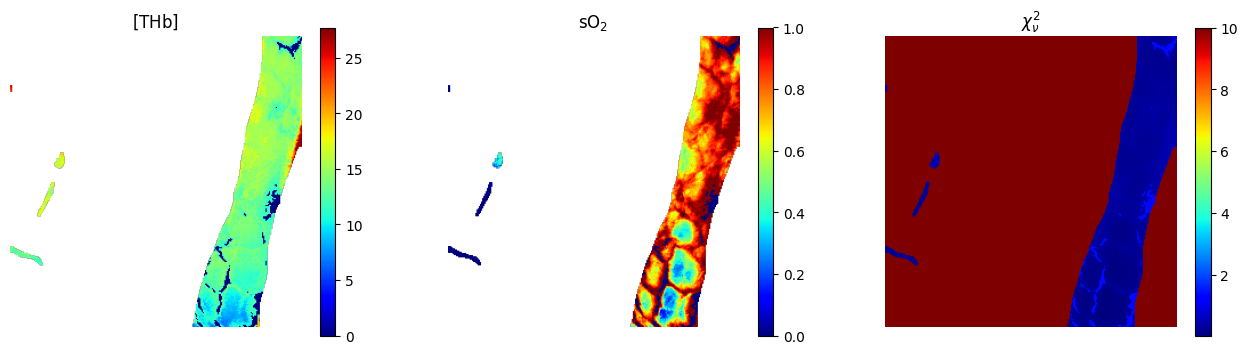

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
im = ax[0].imshow(thb, cmap='jet')
ax[0].set_axis_off()
ax[0].set(title="$\mathrm{[THb]}$")
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(so2, cmap='jet')
fig.colorbar(im, ax=ax[1])
ax[1].set_axis_off()
ax[1].set(title="$\mathrm{sO_2}$")

im = ax[2].imshow(chi_sq, cmap='jet', vmax=10)
fig.colorbar(im, ax=ax[2])
ax[2].set_axis_off()
ax[2].set(title="$\chi^2_\\nu$")
plt.show()

In [17]:
def model(t, s):
    mu_s, mu_a, _ = hemoglobin_mus(A, B, t, s, wavelengths, force_feasible=False)
    mu_s /= (1 - g)
    r = lut(mu_s, mu_a, extrapolate=True) + C
    return r

In [20]:
param_image, chi_sq = hs.fit(
        model,
        x0=[10, 0.5, 0],
        bounds=[(0.0, 0.0, -np.inf), (np.inf, 1.0, np.inf)],
        use_multiprocessing=False,
        pbar=True,
        max_nfev=5000)
thb, so2 = param_image

  0%|          | 0/65536 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [21]:
thb, so2 = param_image[0], param_image[1]

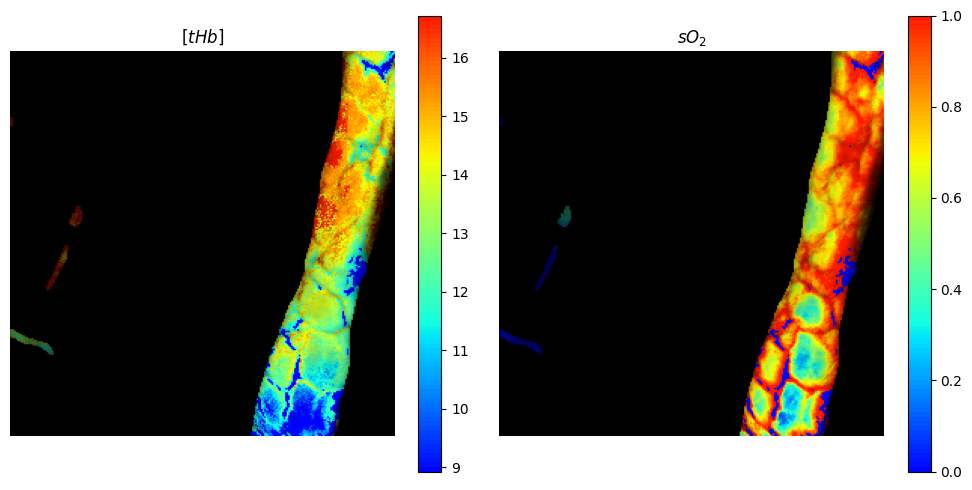

In [19]:
# Create color maps
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for png_name, im, ax in zip(['[tHb]'], [thb], axes.flat):
    im[~mask] = np.nan
    cmin, cmax = np.nanmean(im[mask]) + np.array([-1, 1]) * np.nanstd(im[mask])
    cmin = max(0, cmin)
    color_var, cmap = colorize(im, hb_index, cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.axis('off')
    ax.set_title(f'${png_name}$')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
ax = axes[1]
im = so2.copy()
im[~mask] = np.nan
cmin, cmax = 0, 1
cmin = max(0, cmin)
color_var, cmap = colorize(im, hb_index, cmap=cmap, cmin=cmin, cmax=cmax)
ax.imshow(color_var, cmap=cmap)
ax.axis('off')
ax.set_title(f'$sO_2$')
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
plt.colorbar(sm, ax=ax)

plt.tight_layout()

# ORR

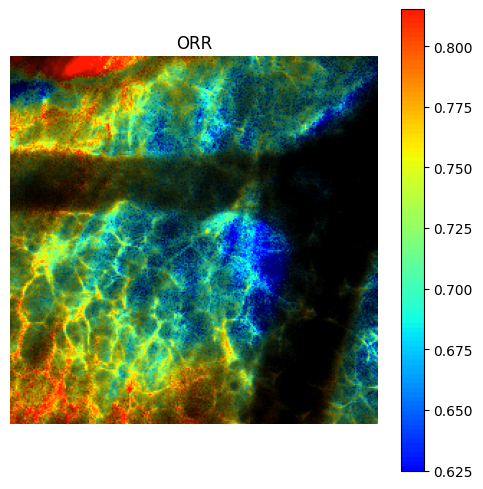

In [20]:
# Load images
orr = OpticalRedoxRatio(
    ex755=ex755_path,
    ex855=ex855_path,
    power_file_path=lsr_pwr_path)

# Down sample for SNR and to match HSDFM
orr.resize_to(256)

# Create outputs
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
cmin, cmax = np.mean(orr.map) + np.array([-2, 2]) * np.std(orr.map)
color_orr, cmap = orr.colorize(cmap=cmap, cmin=cmin, cmax=cmax)
fig = plt.figure(figsize=(5, 5))
plt.imshow(color_orr, cmap=cmap)
ax = plt.gca()
ax.set_title('ORR')
ax.axis('off')
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
plt.colorbar(sm, ax=ax)
plt.tight_layout()

# FLIM

C:\Users\jdivers\PycharmProjects\hsdfmpm\src\hsdfmpm\mpm\flim\flim.py:71: Warning: Loading default IRF file, 'C:\Users\jdivers\.hsdfmpm\irf\irf.pkl'.
  self.calibration = get_irf(irf)


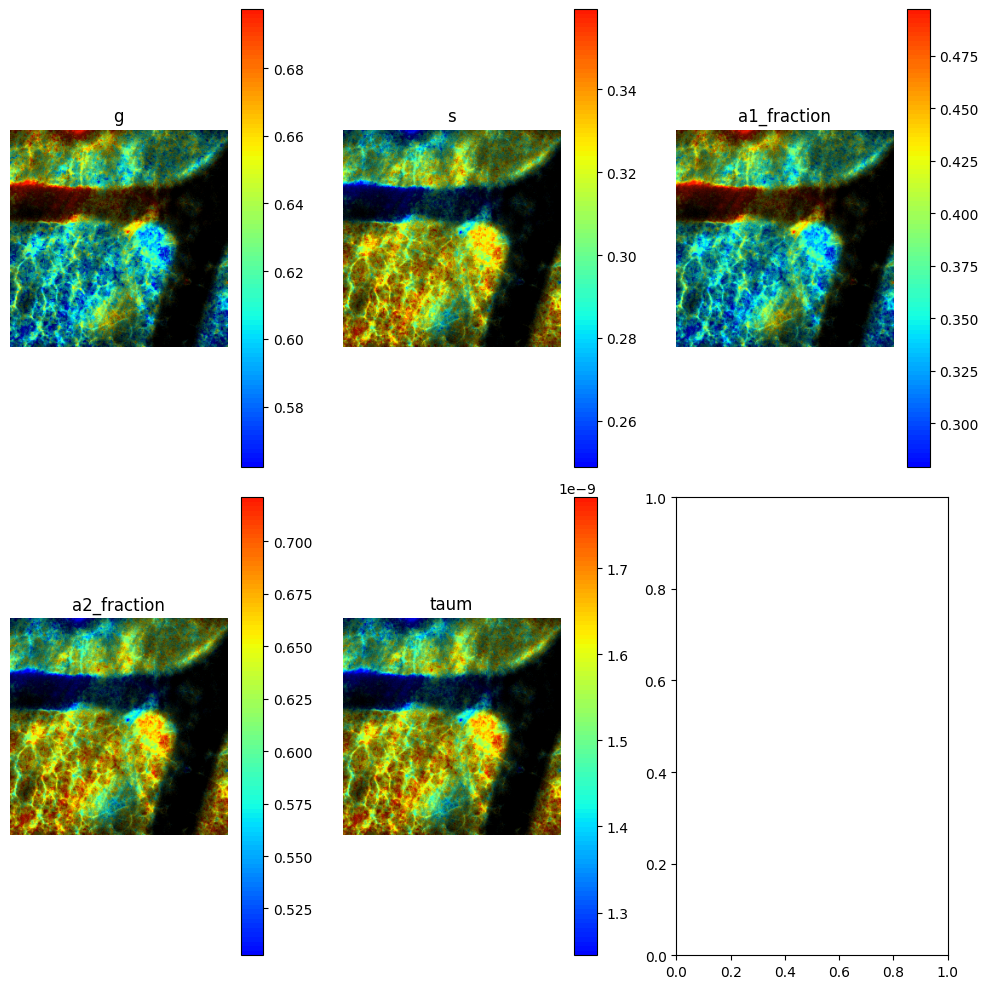

In [21]:
decay = LifetimeImage(image_path=flim_path, channels=0)
decay.load_irf()  # IRF was previously stored
decay.resize_to(256)

# Calculate phasor coords and fit-line endpoints
g, s = decay.phasor_coordinates(threshold=10, median_filter_count=1, k_size=3, correction=True)
alphas, taum, tau = decay.fit_for_lifetime_approximations(median_filter_count=1, k_size=3)
a2_fraction = alphas[1] / (alphas[0] + alphas[1])
a1_fraction = alphas[0] / (alphas[0] + alphas[1])

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for png_name, im, ax in zip(['g', 's', 'a1_fraction', 'a2_fraction', 'taum'], [g, s, a1_fraction, a2_fraction, taum], axes.flat):
    cmin, cmax = np.mean(im) + np.array([-2, 2]) * np.std(im)
    color_var, cmap = colorize(im.squeeze(), np.nansum(decay.decay, axis=-1).squeeze(), cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'{png_name}')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Oxygenation (top) and Metabolic (bottom) Measurements with 100% O$_2$')
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
for name, varim, intim, ax, (cmin, cmax) in zip(
    ['[tHb]', 'sO_2', 'ORR', r'\alpha_2'],
    [thb, so2, orr.map, a2_fraction],
    [(hb_index * mask).squeeze(), (hb_index * mask).squeeze(), ((orr.fad + orr.nadh) / 2).squeeze(), (np.nansum(decay, axis=-1) * np.nansum(decay, axis=-1)).squeeze()],
    axes.flat,
    [(1, 2), (0, 1), (0.55, 0.85), (0.4, 0.8)]
):
    color_var, cmap = colorize(varim, intim, cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'${name}$')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()


In [50]:
from scipy.odr import Model, Data, ODR
mask = ~(np.isnan(g) | np.isnan(s))

# Make a simple linear model
def phasor_line(beta, x):
    """Linear function: S as a function of G"""
    return beta[0] * x + beta[1]

# Init and fit the ODR fitting object
odr = ODR(
    data=Data(g[mask], s[mask]),
    model=Model(phasor_line),
    beta0=[-0.5, 1]
)
output = odr.run()


In [53]:
dir(output)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'beta',
 'cov_beta',
 'delta',
 'eps',
 'info',
 'inv_condnum',
 'iwork',
 'pprint',
 'rel_error',
 'res_var',
 'sd_beta',
 'stopreason',
 'sum_square',
 'sum_square_delta',
 'sum_square_eps',
 'work',
 'work_ind',
 'xplus',
 'y']

In [60]:
svals

array([1542.49582152,  629.7155894 ,  471.85574801,  378.77266623,
        330.02012452,  301.53595115,  284.3498321 ,  281.30713435,
        275.86413802,  273.94040018,  269.3019839 ,  265.46080918,
        263.02122229,  259.99786882,  257.54460858,  254.52363012,
        251.02887407,  249.4211786 ,  247.99016556,  245.44387628,
        244.60830971,  242.54258878,  240.21735827,  238.13480581,
        234.62230388,  230.84081053,  228.59764173,  227.37352992,
        226.41193828,  225.96400829,  221.0814305 ,  220.3106396 ,
        218.86645017,  218.47228918,  215.67653761,  213.77468197,
        213.6651712 ,  209.94069692,  206.4771655 ,  206.00107921,
        204.72050495,  201.23191691,  200.92431407,  198.50652319,
        197.22208836,  195.56502934,  194.816973  ,  193.60466431,
        192.16435516,  189.55998008,  188.48985611,  187.00546928,
        186.53565822,  186.03202043,  184.78885086,  181.60114916,
        181.25160861,  180.24857734,  178.41098591,  176.78770

In [77]:
cloud = np.stack([g.flatten(), s.flatten()], axis=1)
mu = cloud.mean(axis=0)
cloud -= mu  # Center cloud
_, s, vT = np.linalg.svd(cloud, full_matrices=False)

In [81]:
s[0] / s[1]

np.float64(2.357159042625978)

In [80]:
svals[0] / svals[1]

np.float64(2.953583992831893)

In [76]:
aspect_ratio

np.float64(2.9535839928318928)

In [82]:
output.beta

array([-0.67824283,  0.73084826])

In [93]:
aspect_crit = 1 + np.size(g[mask]) / np.sqrt(2 * (np.size(g[mask]) - 1))

In [99]:
import scipy
alpha = 0.05
ratio = aspect_ratio
# Get statistics for non-1 aspect ratio
N = np.size(g[mask])
F_crit = scipy.stats.f.ppf(1 - alpha, 2, N - 3)
aspect_crit = (N - (N - 2)) * F_crit

F_obs = (N - 2) * ratio / N


In [106]:
aspect_crit

np.float64(5.991738445285397)

In [104]:
F_obs

np.float64(2.953493856601643)

In [103]:
p_value = scipy.stats.f.sf(F_obs, 2, N - 3)
p_value

np.float64(0.05216410031225679)

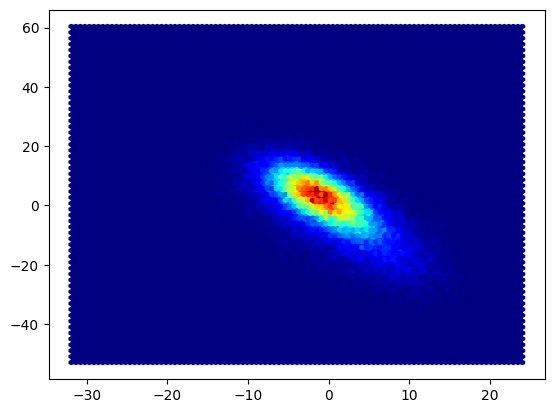

In [73]:
sg, ss = output.cov_beta[0, 0], output.cov_beta[1, 1]
pts_w = np.stack([(g.flatten() - g.mean())/sg, (s.flatten() - s.mean())/ss], axis=1)
plt.hexbin(pts_w[:, 0], pts_w[:, 1], cmap='jet', vmin=1)
u, svals, _ = np.linalg.svd(pts_w, full_matrices=False)
sigma_major, sigma_minor = svals / np.sqrt(len(pts_w) - 1)
aspect_ratio = sigma_major / sigma_minor

In [48]:
output.pprint()

Beta: [-0.67824283  0.73084826]
Beta Std Error: [0.00241955 0.00152635]
Beta Covariance: [[ 0.00973734 -0.00612502]
 [-0.00612502  0.00387507]]
Residual Variance: 0.0006012138312406984
Inverse Condition #: 0.03019845493585033
Reason(s) for Halting:
  Sum of squares convergence


In [201]:
g.var(), s.var()

(np.float64(0.0024772612324809257), np.float64(18.142500220230293))

[(0.0, 1.0), (0.0, 0.6), None]

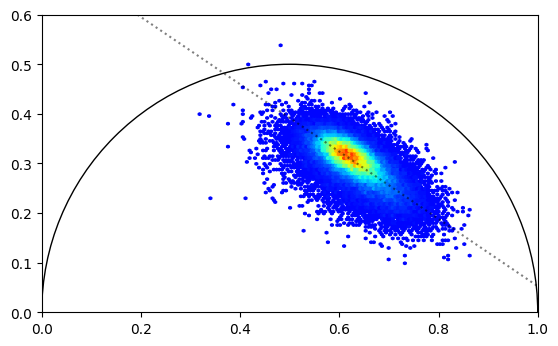

In [40]:
from hsdfmpm.mpm.flim.utils import plot_universal_circle
g, s = decay.phasor_coordinates()
b, m = decay.get_phasor_line()['point-slope']
plt.axline((0, b), slope=m, linestyle=':', color='black', alpha=0.5, label="Fit line")
plt.hexbin(g, s, cmap=cmap, mincnt=1)
plot_universal_circle(decay.omega, harmonic=0.5)
plt.gca().set(xlim=[0, 1], ylim=[0, 0.6], aspect=1)

<ErrorbarContainer object of 3 artists>

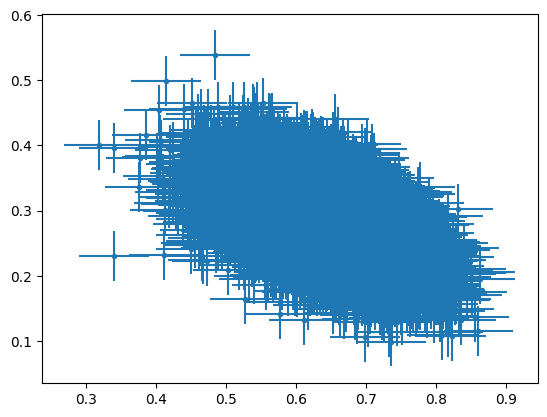

In [43]:
plt.errorbar(g.flatten(), s.flatten(), xerr=np.std(g), yerr=np.std(s), fmt='.')

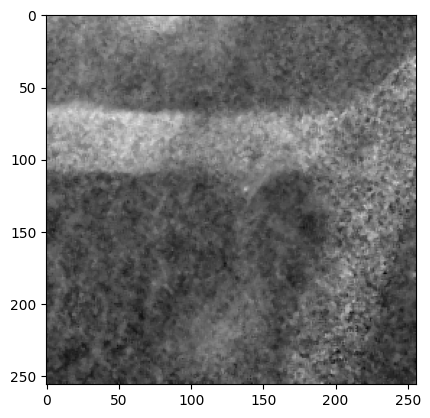

In [426]:
plt.imshow( a1_fraction)

In [454]:
x.item()

216

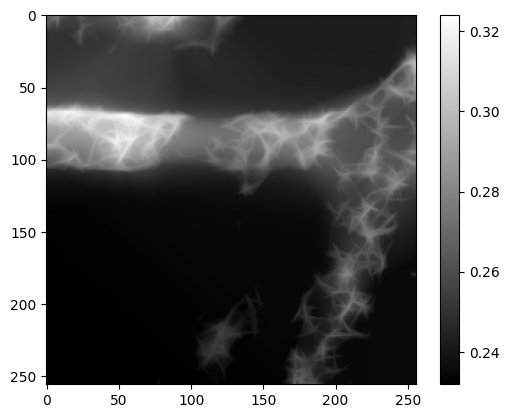

In [465]:
plt.imshow(gabor_s)
plt.colorbar()

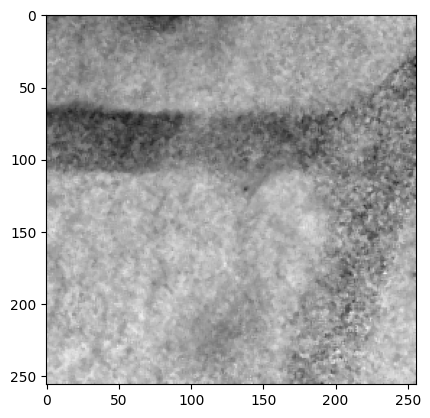

In [533]:
plt.imshow(a2_fraction)

In [663]:
decay.photons

array([[[268., 293., 277., ..., 208., 242., 238.],
        [272., 269., 282., ..., 224., 207., 241.],
        [246., 260., 279., ..., 195., 246., 263.],
        ...,
        [420., 436., 444., ..., 368., 351., 375.],
        [416., 515., 448., ..., 352., 368., 342.],
        [436., 435., 379., ..., 342., 349., 362.]]],
      shape=(1, 256, 256), dtype=float32)

In [698]:
gabo

NameError: name 's_gabor' is not defined

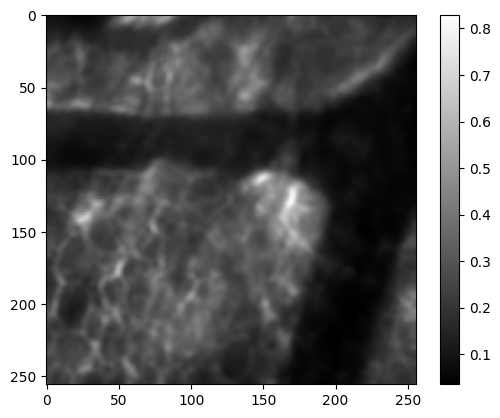

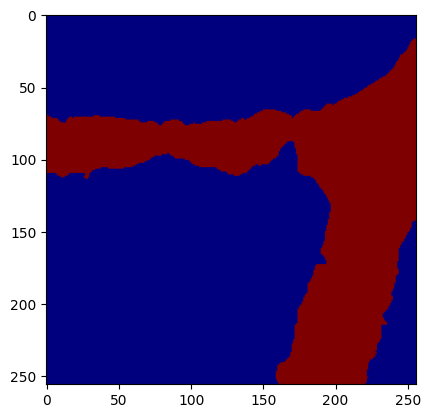

In [108]:
from skimage.segmentation import flood
blurred = cv2.GaussianBlur(orr.nadh, (5,5), 3)
r, c = np.where(blurred == blurred.min())
nadh_mask = flood(blurred, (r.item(), c.item()), tolerance=max(0.15 - orr.nadh.min(), 0))

plt.imshow(blurred)
plt.colorbar()
plt.show()
plt.imshow(nadh_mask, cmap='jet')

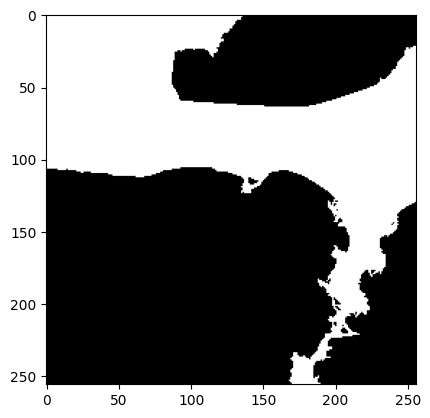

In [473]:
from skimage.morphology import flood
r, c = np.where(gabor_s == gabor_s.max())
plt.imshow(flood(gabor_s, (r.item(), c.item()), tolerance=0.075))

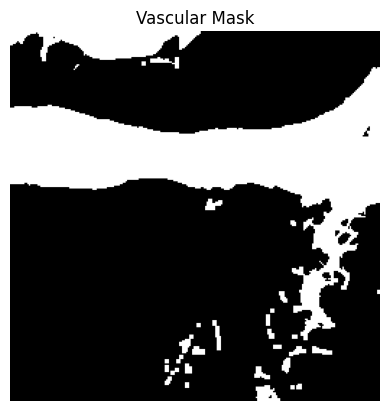

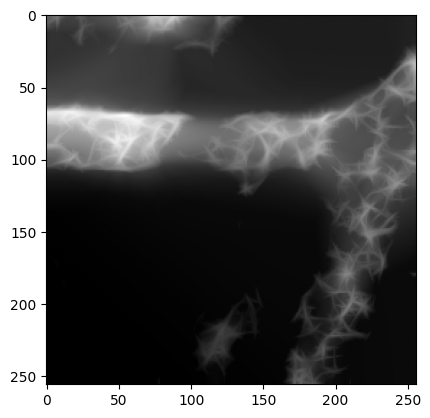

In [441]:
gabor_s = apply_kernel_bank(s.max() - s.squeeze(), gabor_filter_bank(frequency=f, sigma_x=4/f, sigma_y=1/f))

blurred_gabor_response_map = cv2.GaussianBlur(gabor_photons, (3, 3), 0.5)
uint8_resp = (255 * (blurred_gabor_response_map / blurred_gabor_response_map.max())).astype(np.uint8)
threshold = (blurred_gabor_response_map.max() / 255) * cv2.threshold(uint8_resp, 0, 255, cv2.THRESH_OTSU)[0]
otsu_mask = blurred_gabor_response_map > threshold
opened_adaptive_mask = cv2.morphologyEx(
    cv2.adaptiveThreshold(uint8_resp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0),
    cv2.MORPH_OPEN,
    np.ones((3, 3))
).astype(bool)
s_mask = np.logical_or(otsu_mask, opened_adaptive_mask)
fig, ax = plt.subplots(1, 1)
ax.imshow(s_mask)
ax.axis('off')
ax.set_title('Vascular Mask')
plt.show()

plt.imshow(gabor_s)
plt.show()

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from skimage.transform import warp, AffineTransform
from skimage.metrics import normalized_mutual_information
from scipy.optimize import minimize

def register_images_crosscorr(orr_img, so2_img):
    """
    Register two images using phase cross-correlation.

    Parameters:
    - orr_img: numpy.ndarray, reference image
    - so2_img: numpy.ndarray, image to be registered
    - pixel_size: float, scale (um/pixel)

    Returns:
    - registered_img: numpy.ndarray, shifted version of so2_img
    - shift_um: tuple, calculated shift in micrometers (y, x)
    """
    shift_px, error, diffphase = phase_cross_correlation(orr_img, so2_img)
    registered_img = shift(so2_img, shift_px)

    return registered_img, shift_px

def register_images_mutual_info(orr_img, so2_img):
    """
    Register two images using mutual information optimization.

    Parameters:
    - orr_img: numpy.ndarray, reference image
    - so2_img: numpy.ndarray, image to be registered
    - pixel_size: float, scale (um/pixel)

    Returns:
    - registered_img: numpy.ndarray, registered version of so2_img
    - shift_um: tuple, calculated translation in micrometers (y, x)
    """

    def mutual_info_shift(shift):
        transform = AffineTransform(translation=shift)
        shifted_img = warp(so2_img, transform.inverse)
        return -normalized_mutual_information(orr_img, shifted_img)

    initial_shift = [0, 0]
    result = minimize(mutual_info_shift, initial_shift, method='Powell')

    optimal_shift_px = result.x
    transform_optimal = AffineTransform(translation=optimal_shift_px)
    registered_img = warp(so2_img, transform_optimal.inverse)

    return registered_img, transform_optimal.inverse

def display_overlay(orr_img, registered_img, alpha=0.5):
    """
    Display the overlay of two registered images.

    Parameters:
    - orr_img: numpy.ndarray, reference image
    - registered_img: numpy.ndarray, registered image
    - alpha: float, transparency level for overlay
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(orr_img, cmap='gray', interpolation='none')
    plt.imshow(registered_img, cmap='jet', interpolation='none', alpha=alpha)
    plt.title('Overlay of Registered Images')
    plt.axis('off')
    plt.show()

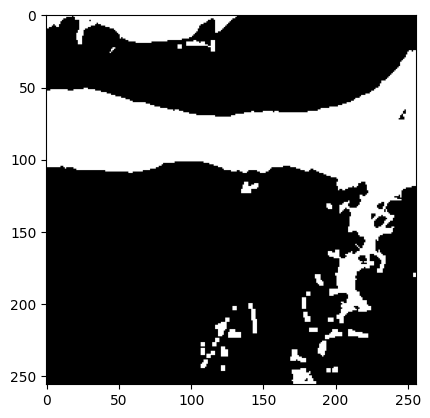

In [566]:
plt.imshow(mask)

[0. 0.]


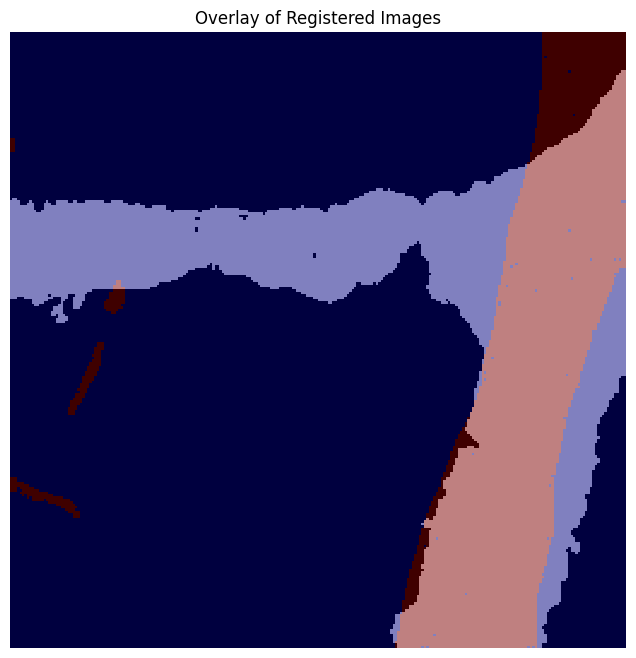

In [570]:
_, reg_shift = register_images_crosscorr(nadh_mask, mask)
print(reg_shift)
display_overlay(nadh_mask, shift(mask, reg_shift), 0.5)

In [109]:
from scipy.ndimage import distance_transform_edt
def distance_to_vasculature(vasc_mask, um_per_pixel=1):
    not_vascualture = ~vasc_mask
    return distance_transform_edt(not_vascualture.astype(np.float32)) * um_per_pixel


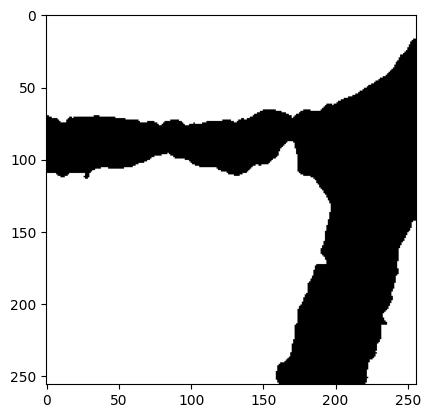

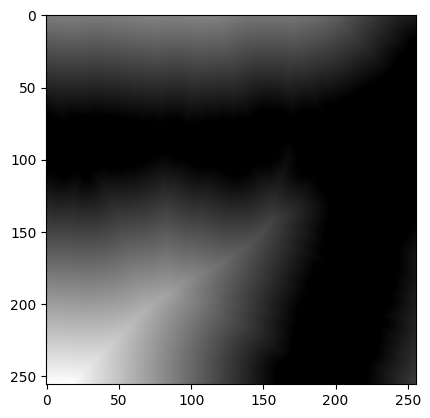

In [112]:
plt.imshow(~nadh_mask)
plt.show()
plt.imshow(dtv)

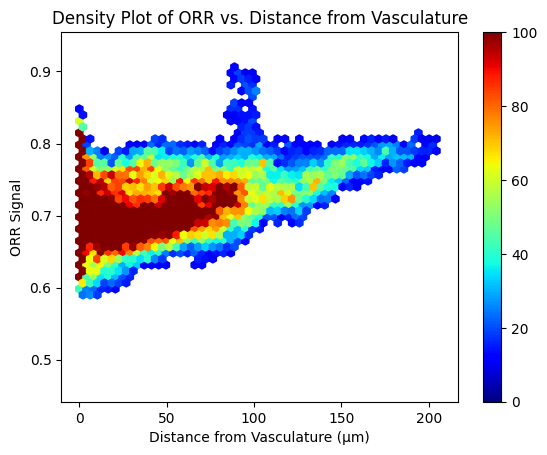

In [111]:
dtv = distance_to_vasculature(nadh_mask, um_per_pixel=1.44)
plt.hexbin(dtv.flatten(), orr.map.flatten(), gridsize=50, cmap='jet', mincnt=10, vmin=0, vmax=100)
plt.colorbar()
plt.xlabel('Distance from Vasculature (µm)')
plt.ylabel('ORR Signal')
plt.title('Density Plot of ORR vs. Distance from Vasculature')
plt.show()

In [174]:
def pO2_of_sO2(sO2, p50, n=2.7):
    return ((sO2 * p50 ** n) / (1 - sO2 ** n)) ** (1 / n)

def pO2_of_vascular_distance(d, diff_limit, pO2_0):
    return pO2_0 * np.exp(-d / diff_limit)

def nadh_of_pO2(pO2, A1, A2, p50, dx):
    return A2 + (A1 + A2) / (1 + np.exp((pO2 - p50) / dx))

def orr_of_nadh(nadh):
    return np.mean(orr.fad.flatten()) / (np.mean(orr.fad.flatten()) + nadh)

def nadh_of_d(d, diff_limit, A1, A2, p50, dx):
    return nadh_of_pO2(
        pO2_of_vascular_distance(
            d, diff_limit, pO2_of_sO2(
                np.nanmean(so2), p50
            )
        ),
        A1, A2, p50, dx
    )

def orr_of_d(d, diff_limit, A1, A2, p50, dx):
    return orr_of_nadh(
        nadh_of_pO2(
            pO2_of_vascular_distance(
                d, diff_limit, pO2_of_sO2(
                    np.nanmean(so2), p50
                )
            ),
            A1, A2, p50, dx,
        )
    )



In [175]:
params

array([9.44669560e+02, 2.16381418e-01, 8.05957562e-02, 9.87198742e-09,
       1.08301056e+03])

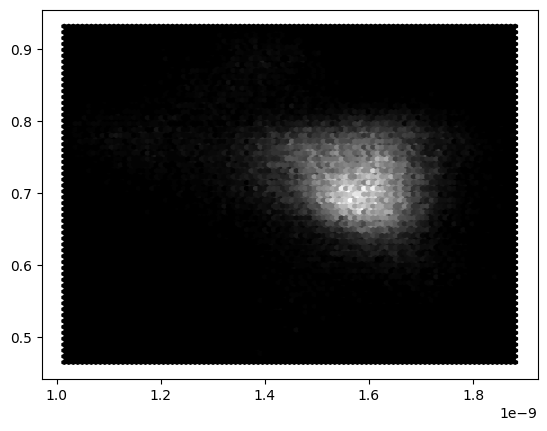

In [185]:
plt.hexbin(taum[~nadh_mask], orr.map[~nadh_mask])

In [189]:
from skimage.restoration import estimate_sigma
estimate_sigma(orr.nadh)

np.float64(0.013025683065955)

In [198]:
(np.var(orr.nadh) / 2) ** 2

np.float64(4.989784343720728e-05)

In [190]:
np.std(orr.nadh)

np.float64(0.11885992224961157)

In [199]:
params, cov, chi_sq

(array([4.59813882e+00, 3.27804590e-01, 2.15308656e-15, 4.16404088e+01,
        2.13829301e+01]),
 array([[ 3.18245641e+00, -6.12793777e-01,  2.30483028e-01,
         -3.45992802e+05, -1.77704143e+05],
        [-6.12793777e-01,  1.18510559e-01, -4.45522828e-02,
          6.62702756e+04,  3.40369132e+04],
        [ 2.30483028e-01, -4.45522828e-02,  1.67526185e-02,
         -2.39227956e+04, -1.22870188e+04],
        [-3.45992802e+05,  6.62702756e+04, -2.39227956e+04,
          2.59705250e+13,  1.33362303e+13],
        [-1.77704143e+05,  3.40369132e+04, -1.22870188e+04,
          1.33362303e+13,  6.84834209e+12]]),
 np.float64(107.07576100300493))

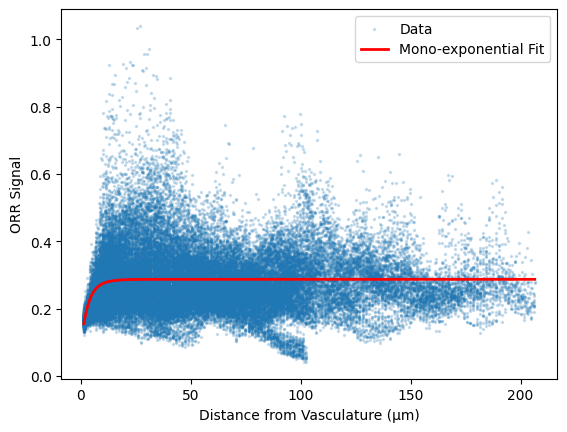

In [202]:
from scipy.optimize import curve_fit

# Fit the curve
x_data = dtv[~nadh_mask]
y_data = orr.nadh[~nadh_mask]
p0 = [100, 0.8, 0.2, 26.6, 1]

params, cov = curve_fit(
    nadh_of_d,
    x_data,
    y_data,
    p0=p0,
    bounds=[
        (0,           0,       0,  0, -np.inf),
        (np.inf, np.inf, np.inf, 160,  np.inf)
    ]
)

# Plot fitted curve
y_fit = nadh_of_d(np.sort(x_data), *params)
df = np.sum(~nadh_mask) - len(p0)
chi_sq = (1 / df) * np.sum((y_data - y_fit) ** 2 / (estimate_sigma(y_data) / 2) ** 2)
plt.scatter(x_data, y_data, s=2, alpha=0.2, label='Data')
plt.plot(np.sort(x_data), y_fit, color='red', linewidth=2, label='Mono-exponential Fit')
plt.xlabel('Distance from Vasculature (µm)')
plt.ylabel('ORR Signal')
plt.legend()
plt.show()

In [203]:
params, cov, chi_sq

(array([4.59813882e+00, 3.27804590e-01, 2.15308656e-15, 4.16404088e+01,
        2.13829301e+01]),
 array([[ 3.18245641e+00, -6.12793777e-01,  2.30483028e-01,
         -3.45992802e+05, -1.77704143e+05],
        [-6.12793777e-01,  1.18510559e-01, -4.45522828e-02,
          6.62702756e+04,  3.40369132e+04],
        [ 2.30483028e-01, -4.45522828e-02,  1.67526185e-02,
         -2.39227956e+04, -1.22870188e+04],
        [-3.45992802e+05,  6.62702756e+04, -2.39227956e+04,
          2.59705250e+13,  1.33362303e+13],
        [-1.77704143e+05,  3.40369132e+04, -1.22870188e+04,
          1.33362303e+13,  6.84834209e+12]]),
 np.float64(107.07576100300493))

In [238]:
import numpy as np
from scipy.optimize import curve_fit

def krogh_profile(r, Pc, Q_over_4D, Rt, Rc):
    return Pc - Q_over_4D * (Rt**2 - r**2 - 2 * Rc**2 * np.log(Rt / r))

# Example: fitting to data
# r_data, ORR_data = ... (your distance and signal arrays)
p0 = [np.max(orr.map), 1e-2, np.max(dtv), np.min(dtv)/2]
params, cov = curve_fit(krogh_profile, dtv.flatten(), orr.map.flatten(), p0=p0,
                        bounds=([0, 0, np.max(dtv), 0], np.inf))
Pc_fit, Q4D_fit, Rt_fit, Rc_fit = params
Q_over_4D_err = np.sqrt(np.diag(cov))[1]

# Plot
import matplotlib.pyplot as plt
r_fit = np.linspace(0.1, Rt_fit, 400)
plt.scatter(dtv.flatten(), orr.map.flatten(), s=5, alpha=0.3, label='data')
plt.plot(r_fit, krogh_profile(r_fit, *params), 'r-', lw=2,
         label='Krogh fit')
plt.xlabel('Distance (µm)')
plt.ylabel('ORR')
plt.legend()
plt.show()


C:\Users\jdivers\AppData\Local\Temp\ipykernel_123364\1876092426.py:5: RuntimeWarning: divide by zero encountered in divide
  return Pc - Q_over_4D * (Rt**2 - r**2 - 2 * Rc**2 * np.log(Rt / r))


ValueError: Residuals are not finite in the initial point.

In [ ]:
plt.scatter(np.arange(256**2), np.sort(orr.nadh.flatten()))